In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = '../data/train.csv'  
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,inc_extraord,taxes,profit,days_rec,ebitda,roa,roe,wc_net,margin_fin,cf_operations
0,17,520288,2011-12-31,28.0,SRL,14.0,NaT,2011,67537.0,1137566.0,...,-309.0,-80959.0,-81288.0,NaN,6318.0,-3.81,-28.03,496258.0,-917029.0,-849.0
1,18,520288,2008-12-31,28.0,SRL,14.0,NaT,2008,256438.0,1181416.0,...,-678.0,-94622.0,-107382.0,NaN,46088.0,-2.76,NaN,97952.0,NaN,-3881.0
2,19,520288,2009-12-31,28.0,SRL,14.0,NaT,2009,194046.0,1152014.0,...,4224.0,-74235.0,-77819.0,NaN,67611.0,-2.17,NaN,-210671.0,NaN,32618.0
3,21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,...,3634.0,-250786.0,-250786.0,NaN,-161478.0,-12.99,NaN,367892.0,-1094962.0,-168907.0
4,22,520288,2007-12-31,28.0,SRL,14.0,NaT,2007,126603.0,1127807.0,...,820.0,92192.0,36733.0,NaN,153060.0,6.20,52.43,-317007.0,-1184970.0,80039.0


In [4]:
quantiles = 50

# Imputation Function
-------
This function will take in a df, aggregate column, and columns that sum to that column. If there is one null, we will take the difference between other columns and the aggregate column as the imputed value. If there is more than one we will take the average of the missing values in each.

def impute_multiple_nulls(df, agg_col, cols_to_sum):
    """
    Impute missing values in a set of columns that are supposed to sum up to an aggregated column.
    If one value is missing, it is imputed as the difference between the aggregated column and the sum of the non-null columns.
    If two or more values are missing, the missing values are replaced by the average difference to balance the total sum.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    agg_col (str): The name of the aggregated column.
    cols_to_sum (list of str): The list of column names that are supposed to sum to the aggregated column.
    
    Returns:
    pd.DataFrame: The dataframe with missing values imputed.
    """
    # Step 1: Identify rows with at least one null in the columns to sum
    df_with_nulls = df[df[cols_to_sum].isna().sum(axis=1) >= 1]
    
    # Step 2: Loop over rows with at least one null
    for index, row in df_with_nulls.iterrows():
        # Get the columns that are missing (NaN)
        missing_columns = row[cols_to_sum].isna()[row[cols_to_sum].isna()].index
        
        # Calculate the sum of the non-null columns
        non_null_sum = row[cols_to_sum].sum()  # Sum of non-null values in the columns to sum
        
        # Calculate the missing value(s)
        missing_value_total = row[agg_col] - non_null_sum
        
        # If there is exactly one missing value, assign it directly
        if len(missing_columns) == 1:
            df.at[index, missing_columns[0]] = missing_value_total
        # If there are two or more missing values, distribute the missing total equally among them
        else:
            avg_missing_value = missing_value_total / len(missing_columns)
            for col in missing_columns:
                df.at[index, col] = avg_missing_value
    
    return df


In [5]:
df['stmt_date'] = pd.to_datetime(df['stmt_date'])

# Check for missing values
missing_values = df.isnull().sum()/len(df) * 100
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

### Impute nulls for 'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current' based on asst_tot

df = impute_multiple_nulls(df, 'asst_tot', ['asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current'])

### Impute nulls for 'debt_bank_lt', 'debt_fin_lt' based on debt_lt

df = impute_multiple_nulls(df, 'debt_lt', ['debt_bank_lt', 'debt_fin_lt'])

### Impute nulls for 'debt_bank_st', 'debt_fin_st' based on debt_st

df = impute_multiple_nulls(df, 'debt_st', ['debt_bank_st', 'debt_fin_st'])

# Check for missing values
missing_values = df.isnull().sum()/len(df) * 100
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

In [6]:
## Default within a Year (Definition may be adjusted later)

df['stmt_date'] = pd.to_datetime(df['stmt_date'])
df['def_date'] = pd.to_datetime(df['def_date'])

# Calculate 1 year after stmt_date
one_year_after = df['stmt_date'] + pd.DateOffset(years=1)

# Define default if def_date is between stmt_date and one_year_after
df['default'] = ((df['def_date'] >= df['stmt_date']) & (df['def_date'] <= one_year_after)).astype(int)

df['default'].mean()

np.float64(0.0112783717876571)

# Total Assets

In [7]:
df['asset_quantile'] = pd.qcut(df['asst_tot'], q=quantiles, labels=False) 

## Conditional Probability of Default for Total Assets

In [8]:
df['asset_quantile'] = pd.qcut(df['asst_tot'], q=quantiles, labels=False, duplicates="drop")  # 4 quantiles (quartiles)

# 3. Liabilities / Assets: (financial leverage)
-----
For this to work, we have to be somewhat sure that our total Liabilities field we calculated makes sense. The above check that total assets = total liabilities + equity shows that it is at least close. **It is possible we are missing something in calculating our total liabilities though and if we are then this could be impacted.** 

In [9]:
df['liab_tot'] = df['debt_st'] + df['debt_lt'] 
df['financial_leverage'] = df['liab_tot'] / df['asst_tot']
df['financial_leverage_quantile'] = pd.qcut(df['financial_leverage'], q=quantiles, labels=False, duplicates="drop")  # 4 quantiles (quartiles)

# 4. Net Income / Assets: (Profitability ratio)
---
Here, profit is same as net income I believe... We have no nulls in profit or in total assets, so we should be ok. Total assets appears to check out. **Still need to do QC on profit (does it check out with revenue - costs?)**

In [10]:
df['profitability_ratio'] = df['profit'] / df['asst_tot']
df['profitability_ratio_quantile'] = pd.qcut(df['profitability_ratio'], q=quantiles, labels=False, duplicates="drop")  # 4 quantiles (quartiles)

# 5. Net Income Growth
----
As discussed in our meeting, there are some significant challenges to using this. I am going to leave this for later...

### INF and -INF come from profit == 0
check to see if this makes sense

In [11]:
df[df['profit'] == 0][['profit','ebitda']].groupby('ebitda').size().sort_values().reset_index()

,ebitda,0
0,-9411099.0,1
1,80924.0,1
2,80227.0,1
3,80119.0,1
4,79913.0,1
...,...,...
1341,-6.0,2
1342,2.0,2
1343,1.0,3
1344,500.0,3


### if ebitda = 0 as well, we think that profit could be 0 in truth (set to 1 so we dont have issues)
### if ebitda != 0, we will set to ebitda

In [12]:
df['profit'] = df.apply(lambda row: 1 if row['profit'] == 0 and row['ebitda'] == 0
                        else row['ebitda'] if row['profit'] == 0 and row['ebitda'] != 0
                        else row['profit'], axis=1)

In [13]:
df = df.sort_values(by=['id', 'stmt_date'])
# Calculate Net Income Growth by ID and sorted by statement_date
df['net_income_growth'] = df.groupby('id')['profit'].pct_change()
#fill first with 0 as we don't know percent change
df['net_income_growth'].fillna(0, inplace=True)
df['net_income_growth_quantile'] = pd.qcut(df['net_income_growth'], q=quantiles, labels=False, duplicates='drop')  # 4 quantiles (quartiles)

In [14]:
print(df.sort_values(['id','stmt_date'])[['id','stmt_date','profit','net_income_growth']].head(10000).to_markdown())

|         |        id | stmt_date           |            profit |   net_income_growth |
|--------:|----------:|:--------------------|------------------:|--------------------:|
|       4 |    520288 | 2007-12-31 00:00:00 |   36733           |         0           |
|       1 |    520288 | 2008-12-31 00:00:00 | -107382           |        -3.92331     |
|       2 |    520288 | 2009-12-31 00:00:00 |  -77819           |        -0.275307    |
|       5 |    520288 | 2010-12-31 00:00:00 |  -83593           |         0.0741978   |
|       0 |    520288 | 2011-12-31 00:00:00 |  -81288           |        -0.0275741   |
|       3 |    520288 | 2012-12-31 00:00:00 | -250786           |         2.08515     |
|       8 |   1400357 | 2008-12-31 00:00:00 |  -25530           |         0           |
|       7 |   1400357 | 2009-12-31 00:00:00 |    8139           |        -1.3188      |
|       6 |   1400357 | 2010-12-31 00:00:00 |   45385           |         4.57624     |
|       9 |   1400357 | 2011-12-

# 6. Quick Ratio: (LiquidAssets:Current Liabilities)
---
There are a few cheat sheet formulas to consider:
1. (current assets - inventory) / current liabilities
- This cant work as we don't have inventory
2. (Cash + marketable securities + net receivabl) / current liabilities
- this maybe can work, we have AR and AP_st and AP_lt so can do net receivables 
3. (cash + cash equivalents + short term investments + current recievables) / current liabilities
- we dont exactly have short term recievables but can use AR instead...

-----
**CALC of short term liabilities is an open question here**
If we just use debt st that would seem to line up with earlier interpretation of total liabilities. But doesn't quite make logical sense.... Regardless this is how I will proceed for now.

----
We have 2 versions below using what we have from 2. and 3. above. V1 seems more ideal to me, but it will have issues with NAs

#### We have an issue if short term debt is 0. I will choose to set quick ratio to a high but not infinite value

In [15]:
print(df[df['debt_st'] == 0].size, df[df['debt_st'] != 0].size)
df.groupby(['debt_st']).size().sort_values().reset_index()

89676 54158580


,debt_st,0
0,-77594263.0,1
1,2601727.0,1
2,2601728.0,1
3,2601742.0,1
4,2601745.0,1
...,...,...
912952,2000.0,18
912953,1040.0,18
912954,1000.0,22
912955,788387.0,267


In [16]:
#v2: (cash + cash equivalents + short term investments + current recievables) / current liabilities
# we cant find current recievables so must use all recievables
df['quick_ratio_v2'] = np.where(df['debt_st'] == 0, 100, (df['cash_and_equiv'] + df['AR']) / df['debt_st'])
df['quick_ratio_v2_quantile'] = pd.qcut(df['quick_ratio_v2'], q=quantiles, labels=False, duplicates='drop')  # 4 quantiles (quartiles)

In [17]:
null_counts = df[['cash_and_equiv', 'AR', 'debt_st','quick_ratio_v2','quick_ratio_v2_quantile']].isnull().sum()
print(null_counts)

cash_and_equiv             17
AR                         12
debt_st                     5
quick_ratio_v2             20
quick_ratio_v2_quantile    20
dtype: int64


In [18]:
df.groupby(['quick_ratio_v2']).size()


quick_ratio_v2
-2.349320e+05    1
-8.093067e+04    1
-3.844810e+04    1
-3.383229e+04    1
-2.117672e+04    1
                ..
 1.211815e+06    1
 1.356617e+06    1
 2.188114e+06    1
 3.146279e+06    1
 7.298477e+06    1
Length: 1021039, dtype: int64

# 7. Retained Earnings / Assets: Indicates long-term financial stability.
----
We don't have an exact proxy for retained earnings (basically we don't know what portion of profit is retained versus not):

**DEF:**
Retained earnings are the cumulative net earnings or profits of a company after accounting for dividend payments. As an important concept in accounting, the word “retained” captures the fact that because those earnings were not paid out to shareholders as dividends, they were instead retained by the company.


# 8.  Sales Growth: Measures the growth trajectory of a firm's revenue.
------

Again, I am going to leave this for now given the dificulties discussed in our meeting with Prof

#### Have issue with 0 operating revenue

In [19]:
df.groupby('rev_operating').size().sort_values()

rev_operating
-111729936.0        1
 4156713.0          1
 4156716.0          1
 4156735.0          1
 4156758.0          1
                ...  
 120000.0         311
 3.0              312
 2.0              592
 1.0             2145
 0.0            31217
Length: 890171, dtype: int64

In [20]:
df[df['rev_operating'] == 0][['rev_operating','ebitda']].groupby('ebitda').size().sort_values().reset_index()

,ebitda,0
0,-92420171.0,1
1,-9865.0,1
2,-9869.0,1
3,-9873.0,1
4,-9875.0,1
...,...,...
23224,-311.0,19
23225,-511.0,40
23226,-310.0,49
23227,-510.0,83


### if ebitda > 0 as well, we will use ebitda as a proxy
### if ebitda <= 0 we will set to 1 like sales

In [21]:
# Define sales_proxy based on specified conditions
df['rev_operating'] = df.apply(lambda row: 
                             row['ebitda'] if row['rev_operating'] == 0 and row['ebitda'] > 0 
                             else 1 if row['rev_operating'] == 0 and row['ebitda'] <= 0
                             else row['rev_operating'], axis=1)
df['rev_operating'] = df['rev_operating'].fillna(df['ebitda']).fillna(1)

In [22]:
df[df['rev_operating'] == 0][['rev_operating','ebitda']].groupby('ebitda').size().sort_values().reset_index()

,ebitda,0
0,0.0,132


In [23]:
df['rev_operating'].isna().sum()

np.int64(0)

In [24]:
df = df.sort_values(by=['id', 'stmt_date'])
# Calculate Net Income Growth by ID and sorted by statement_date
df['sales_growth'] = df.groupby('id')['rev_operating'].pct_change()
#fill first with 0 as we don't know percent change
df['sales_growth'].fillna(0, inplace=True)
# Apply qcut with duplicates="drop" to avoid duplicate bin edges
df['sales_growth_quantile'] = pd.qcut(df['sales_growth'], q=quantiles, labels=False, duplicates="drop")

In [25]:
print(df.sort_values(['id','stmt_date'])[['id','stmt_date','rev_operating','sales_growth']].head(10000).to_markdown())

|         |        id | stmt_date           |     rev_operating |      sales_growth |
|--------:|----------:|:--------------------|------------------:|------------------:|
|       4 |    520288 | 2007-12-31 00:00:00 |       2.04116e+06 |       0           |
|       1 |    520288 | 2008-12-31 00:00:00 |  967389           |      -0.526058    |
|       2 |    520288 | 2009-12-31 00:00:00 |  638687           |      -0.339783    |
|       5 |    520288 | 2010-12-31 00:00:00 |  564622           |      -0.115964    |
|       0 |    520288 | 2011-12-31 00:00:00 |  538081           |      -0.0470067   |
|       3 |    520288 | 2012-12-31 00:00:00 |  319790           |      -0.405684    |
|       8 |   1400357 | 2008-12-31 00:00:00 |   47944           |       0           |
|       7 |   1400357 | 2009-12-31 00:00:00 |       1.03761e+06 |      20.6421      |
|       6 |   1400357 | 2010-12-31 00:00:00 |       1.34821e+06 |       0.29934     |
|       9 |   1400357 | 2011-12-31 00:00:00 |       1.

In [26]:
df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asset_quantile', 'liab_tot', 'financial_leverage',
       'financial_leverage_quantile', 'profitability_ratio',
       'profitability_ratio_quantile', 'net_income_growth',
       'net_income_growth_quantile', 'quick_ratio_v2',
       'quick_ratio_v2_quantile', 'sales_growth', 'sales_growth_quantile'],
      dtype='object')

# 9. Cash / Assets: 

In [27]:
df['cash_assets_ratio'] = df['cash_and_equiv'] / df['asst_tot']
df['cash_assets_ratio_quantile'] = pd.qcut(df['cash_assets_ratio'], q=quantiles, labels=False, duplicates="drop")  # 4 quantiles (quartiles)


# 10. Debt Service Coverage Ratio: Evaluates the firm's ability to cover debt payments from its earnings.
---
**DEF**:
EBIT/interest

----
WE have ebitda rathter than ebit, and we have exp_financing which captures expensese of financing such as interest...

---
**ISSUE**: exp_financing can be 0, in which case this ratio will not be defined...

For now I think we can set 0 to 1, but this **must be revisisted....**

In [28]:
#set 0 to 1 for exp_financing
df['exp_financing'] = df['exp_financing'].replace(0, 1)

df['dscr'] = df['ebitda'] / df['exp_financing']
df['dscr_quantile'] = pd.qcut(df['dscr'], q=quantiles, labels=False, duplicates="drop")  # 4 quantiles (quartiles)

In [29]:
# Check for missing values
missing_values = df.isnull().sum()/len(df) * 100
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
eqty_corp_family_tot            100.000000
def_date                         94.585131
days_rec                         72.317870
debt_fin_st                      11.994701
debt_bank_st                     11.853917
AP_st                            11.785918
AP_lt                             9.012146
debt_fin_lt                       8.994951
debt_bank_lt                      8.887775
roe                               7.125871
sales_growth_quantile             4.000188
margin_fin                        3.982016
prof_financing                    0.064091
dscr_quantile                     0.039568
dscr                              0.039568
exp_financing                     0.035856
inc_extraord                      0.029798
liab_lt                           0.028724
HQ_city                           0.027063
asst_fixed_fin                    0.023155
asst_intang_fixed                 0.015827
liab_lt_emp                       0.015827
financial_leverage_quantile       0.0152

Feature: asst_tot - Number of null values: 0


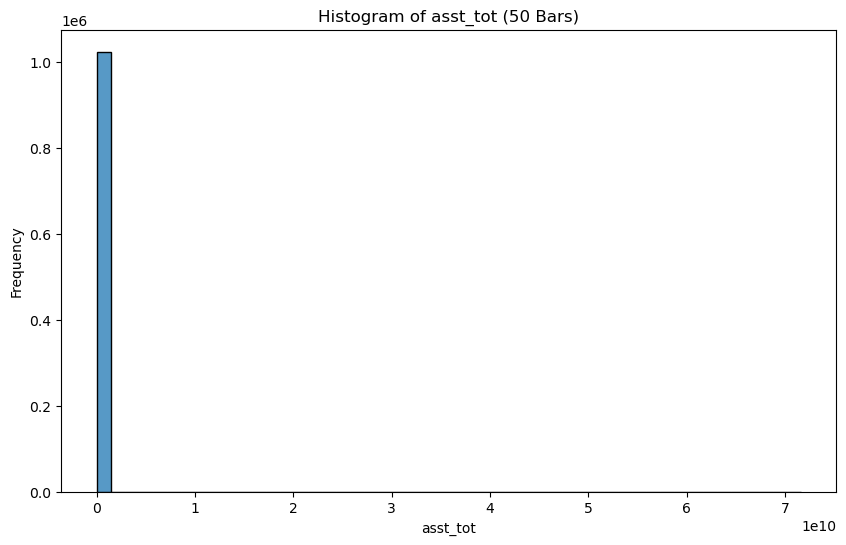

Feature: asset_quantile - Number of null values: 0


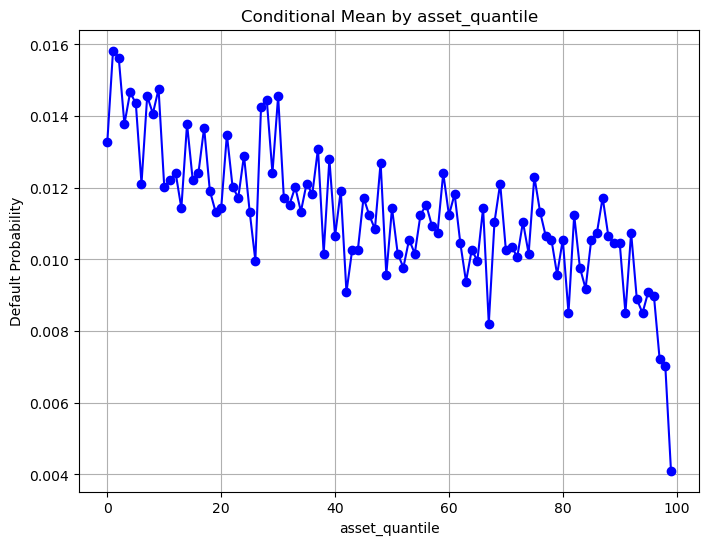

Feature: financial_leverage - Number of null values: 156


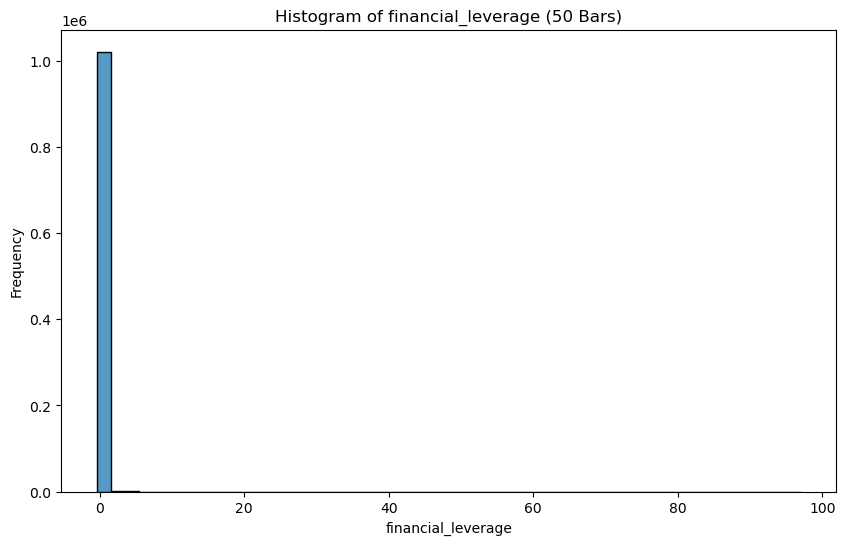

Feature: financial_leverage_quantile - Number of null values: 156
Cutoff values for financial_leverage_quantile:
[-0.41400349  0.23506276  0.41689418  0.5523542   0.65927275  0.74607927
  0.81935483  0.88152165  0.9348059   0.97848273 97.07777557]


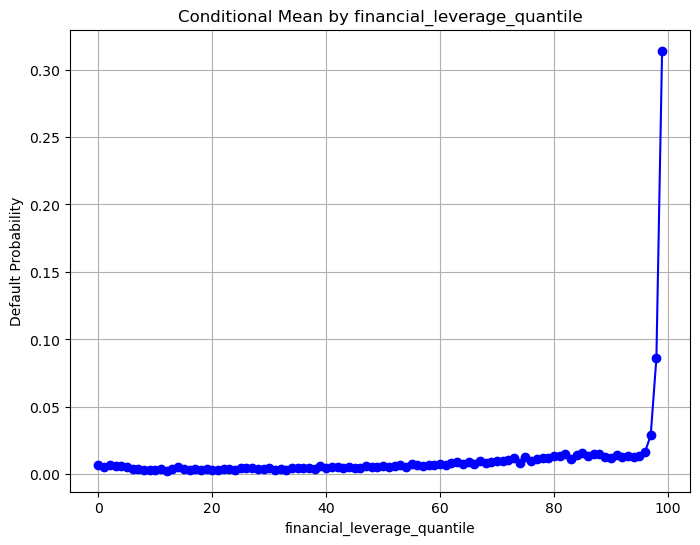

Feature: profitability_ratio - Number of null values: 20


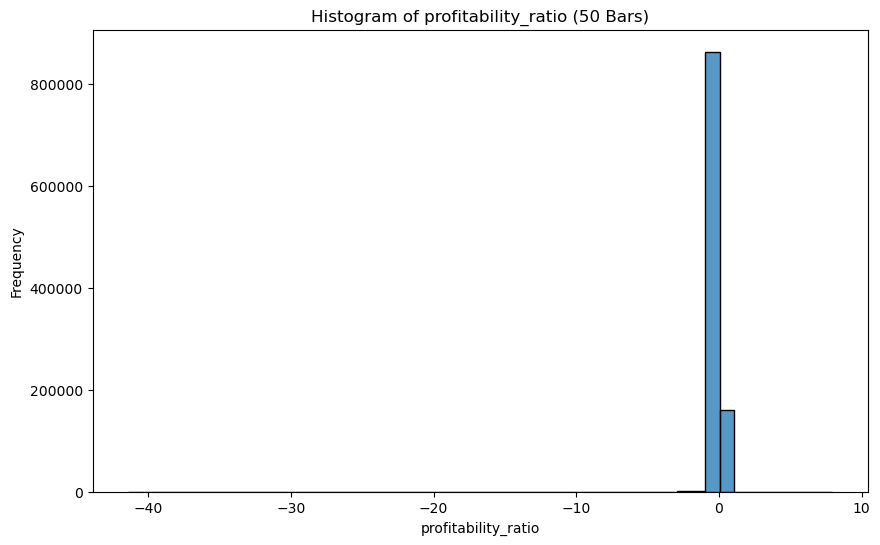

Feature: profitability_ratio_quantile - Number of null values: 20
Cutoff values for profitability_ratio_quantile:
[-4.14200057e+01 -3.32613744e-02 -1.07502328e-02 -2.70295198e-03
  6.63898443e-04  2.94423904e-03  7.09918603e-03  1.45191242e-02
  2.85971392e-02  6.15737973e-02  7.93641684e+00]


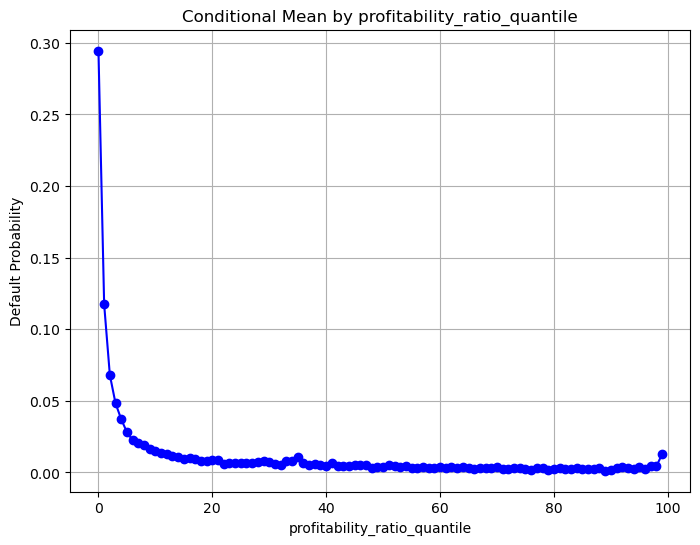

Feature: net_income_growth - Number of null values: 0


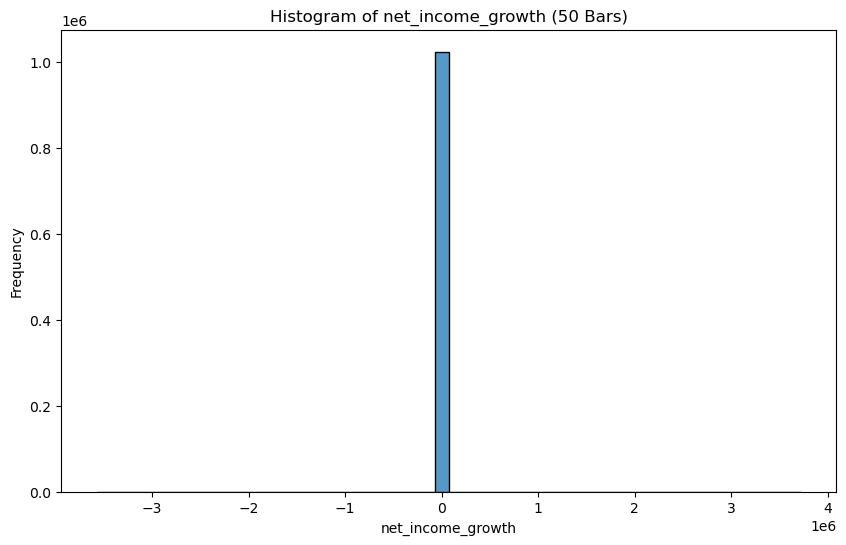

Feature: net_income_growth_quantile - Number of null values: 0
Cutoff values for net_income_growth_quantile:
[-3.57537500e+06 -1.90437138e+00 -9.38532236e-01 -5.60103970e-01
 -2.06046035e-01  0.00000000e+00  8.53417880e-03  4.43817645e-01
  1.86649316e+00  3.72484000e+06]


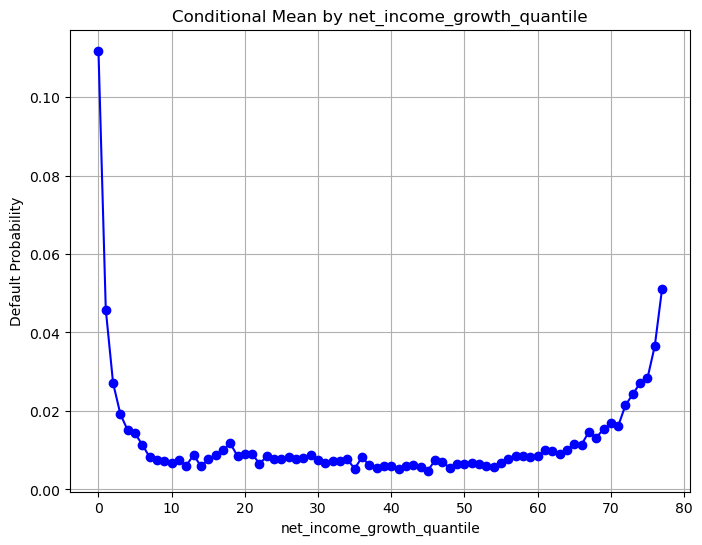

Feature: quick_ratio_v2 - Number of null values: 20


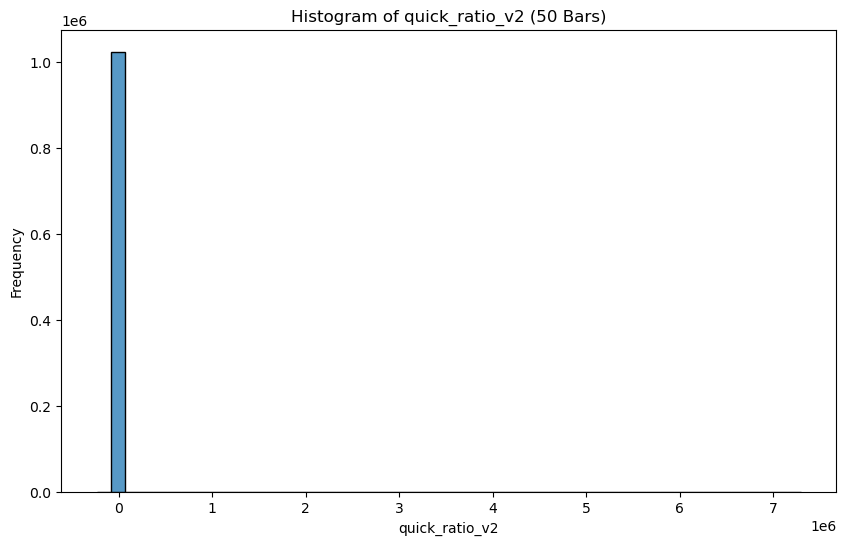

Feature: quick_ratio_v2_quantile - Number of null values: 20
Cutoff values for quick_ratio_v2_quantile:
[-2.34932000e+05  1.18311631e-01  2.75973666e-01  4.62050982e-01
  6.34021459e-01  7.92371878e-01  9.56002248e-01  1.15052917e+00
  1.54566971e+00  2.80378817e+00  7.29847700e+06]


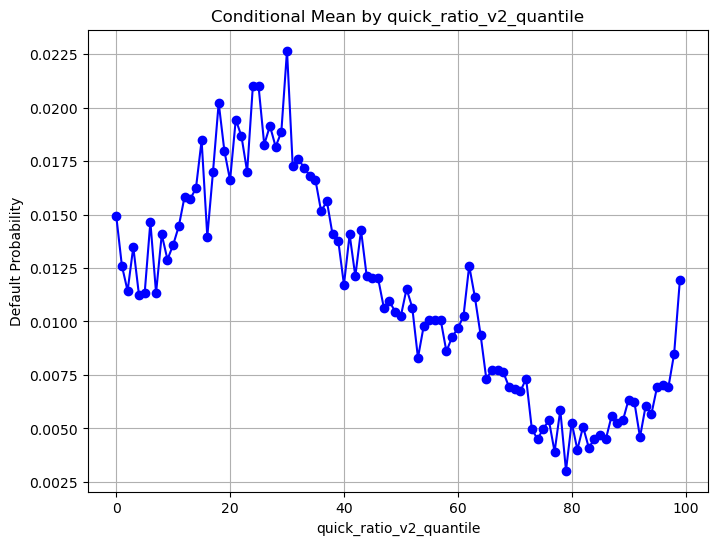

Feature: sales_growth - Number of null values: 0


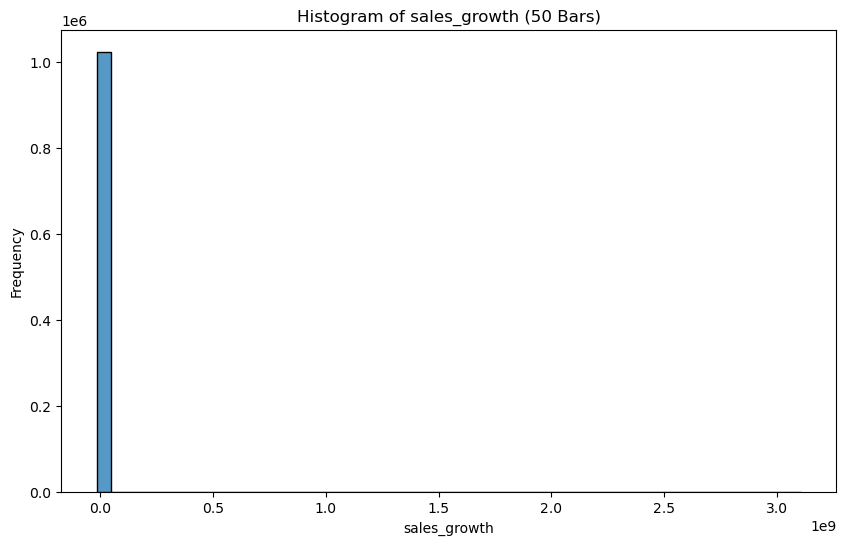

Feature: sales_growth_quantile - Number of null values: 20472
Chart wouldn't work for quantile plot of sales_growth_quantile: missing values must be missing in the same location both left and right sides
Feature: cash_assets_ratio - Number of null values: 17


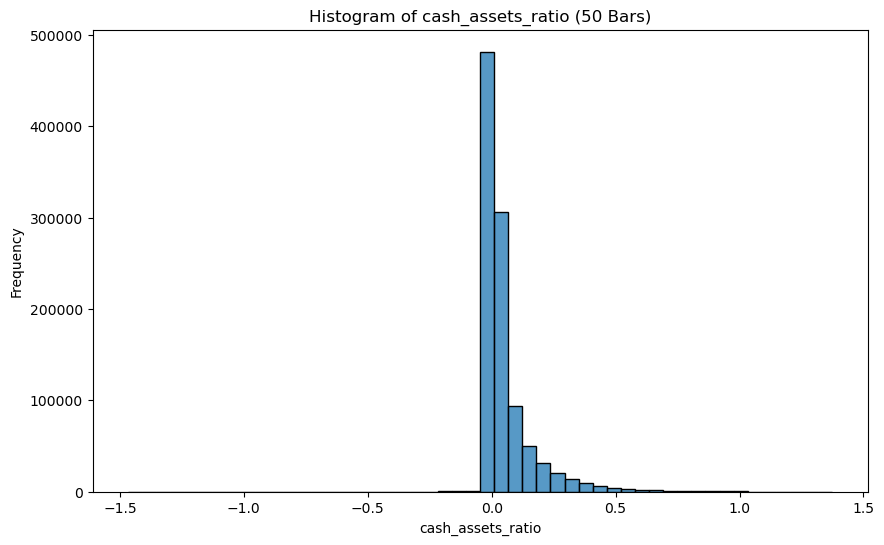

Feature: cash_assets_ratio_quantile - Number of null values: 17
Cutoff values for cash_assets_ratio_quantile:
[-1.46853336e+00  2.03078545e-04  9.14570791e-04  2.53817662e-03
  5.80600558e-03  1.19337293e-02  2.29522560e-02  4.28111182e-02
  8.06248191e-02  1.65782833e-01  1.37441997e+00]


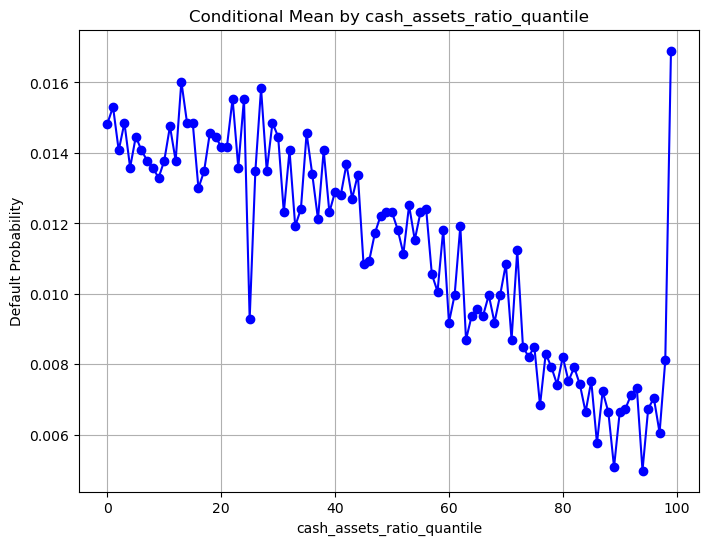

Feature: dscr - Number of null values: 405


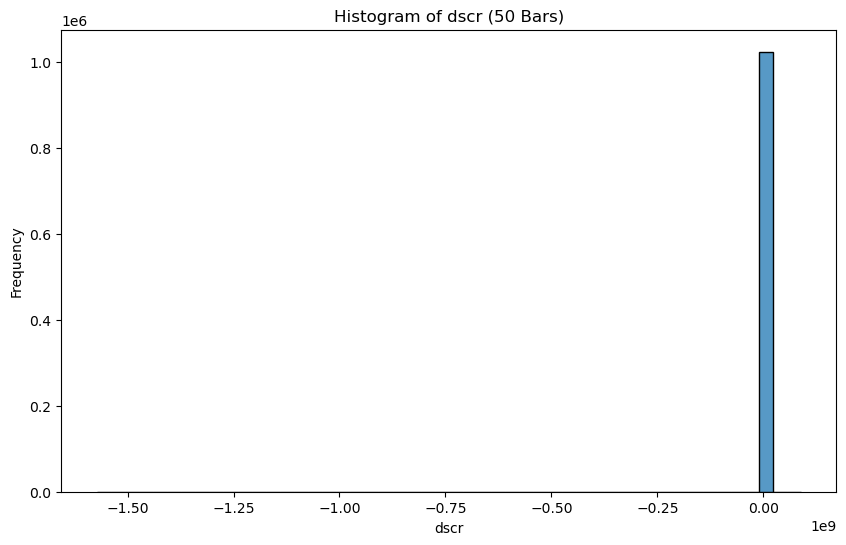

Feature: dscr_quantile - Number of null values: 405
Cutoff values for dscr_quantile:
[-1.57287030e+09 -2.42850118e+00  5.67189664e-01  1.38027896e+00
  2.18163650e+00  3.20263540e+00  4.94137230e+00  8.74077859e+00
  2.09891432e+01  1.18664070e+02  8.91031700e+07]


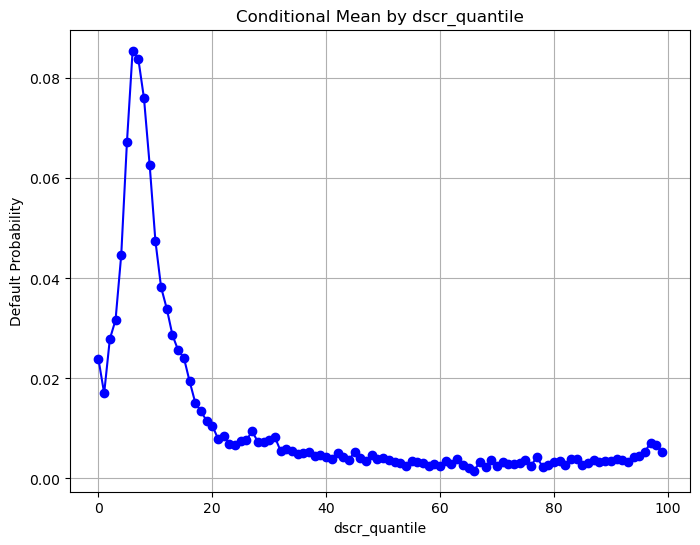

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Define all features and quantiles for plotting
features = [
    'asst_tot', 'asset_quantile',
    'financial_leverage', 'financial_leverage_quantile',
    'profitability_ratio', 'profitability_ratio_quantile',
    'net_income_growth', 'net_income_growth_quantile',
    'quick_ratio_v2', 'quick_ratio_v2_quantile',
    'sales_growth', 'sales_growth_quantile',
    'cash_assets_ratio', 'cash_assets_ratio_quantile',
    'dscr', 'dscr_quantile'
]

# Loop over all features, checking their presence in the DataFrame
for feature in features:
    if feature in df.columns:
        # 1. Print the number of null values for each feature
        null_count = df[feature].isnull().sum()
        print(f"Feature: {feature} - Number of null values: {null_count}")

        # 2. Plot histogram for non-quantile features
        if 'quantile' not in feature:
            try:
                plt.figure(figsize=(10, 6))
                sns.histplot(df[feature], bins=50)
                plt.title(f'Histogram of {feature} (50 Bars)')
                plt.xlabel(feature)
                plt.ylabel('Frequency')
                plt.show()
            except Exception as e:
                print(f"Chart wouldn't work for histogram of {feature}: {e}")

        # 3. For quantile features, print cutoff values and plot conditional default graph
        if 'quantile' in feature:
            try:
                # Print quantile cutoff values
                original_feature = feature.replace('_quantile', '')
                if original_feature in df.columns:
                    quantiles_cutoffs = pd.qcut(df[original_feature], q=10, retbins=True, duplicates="drop")[1]
                    print(f"Cutoff values for {feature}:")
                    print(quantiles_cutoffs)

                # Calculate conditional mean using 'default' if available, else using the first non-quantile feature
                if 'default' in df.columns:
                    quantile_rate = df.groupby(feature)['default'].mean()
                else:
                    quantile_rate = df.groupby(feature)[features[0]].mean()  # Use first non-quantile feature as fallback

                # Plot conditional mean or default probability
                plt.figure(figsize=(8, 6))
                plt.plot(quantile_rate.index, quantile_rate.values, marker='o', linestyle='-', color='b')
                plt.title(f'Conditional Mean by {feature}')
                plt.xlabel(feature)
                plt.ylabel('Default Probability' if 'default' in df.columns else f'Mean {features[0]}')
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Chart wouldn't work for quantile plot of {feature}: {e}")
    else:
        print(f"Feature: {feature} - Not found in DataFrame")


In [39]:
df[features].isna().sum()

asst_tot                            0
asset_quantile                      0
financial_leverage                156
financial_leverage_quantile       156
profitability_ratio                20
profitability_ratio_quantile       20
net_income_growth                   0
net_income_growth_quantile          0
quick_ratio_v2                     20
quick_ratio_v2_quantile            20
sales_growth                        0
sales_growth_quantile           20472
cash_assets_ratio                  17
cash_assets_ratio_quantile         17
dscr                              405
dscr_quantile                     405
dtype: int64